In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

In [2]:
def FonctionImportDonnees(chemin):
    """
        importe les données du fichier excel, après expertise
    """
    donnees=pd.ExcelFile(chemin).parse(1) #Sélectionne la première feuille
    donnees=donnees.drop(index=[960,952]) #Supprime les lignes avec trop de NA
    donnees=donnees.drop('5°C T50 (h)',axis=1).drop('5°C T50 (j)',axis=1).drop('5°C TMG (h)',axis=1) #Supprime les colonnes avec information identique, ou avec trop de NA
    
    liste=[]
    col={}
    j=0
    
    for i in range(10,16): #Expertise: création des données de croissance
        a=donnees.columns[i]
        b=donnees.columns[i+1]
        liste.append(donnees[b]-donnees[a])
        c='v'+a+'-'+b
        col[j]=c.replace(' ','')
        j=j+1
    croissance=pd.DataFrame(liste).T
    croissance=croissance.rename(col, axis='columns')
    donnees=pd.concat([donnees,croissance],axis=1).dropna()
    donnees.set_index('rep')
    
    donnees=donnees[['Bancs', 'Pop', 'Echantillon', 'rep', 'N° rep', 'camera', 'semis','zone', '5°C TMG (j)', 'Aire sous la courbe', 'v15j-16j', 'v16j-17j', 'v17j-18j','v18j-19j', 'v19j-20j', 'v20j-21j']]
    
    quanti=['5°C TMG (j)', 'Aire sous la courbe', 'v15j-16j', 'v16j-17j', 'v17j-18j','v18j-19j', 'v19j-20j', 'v20j-21j']
    quali=['Bancs', 'Pop', 'N° rep', 'camera', 'semis','zone']
    
    return donnees,quanti,quali

#IMPORTATION DES DONNEES EXPERTISEES
donnees,quanti,quali = FonctionImportDonnees("https://raw.githubusercontent.com/etudiantdatascience/TER-reduction-dimension/master/Data/semis.xlsx")


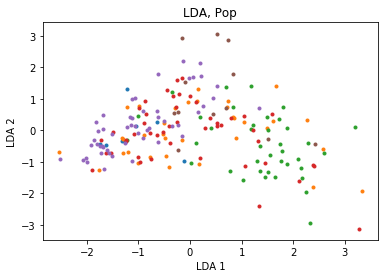

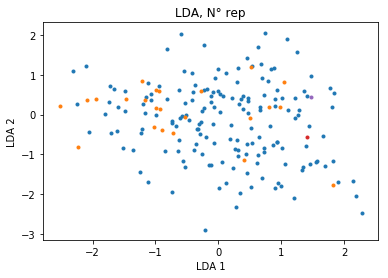

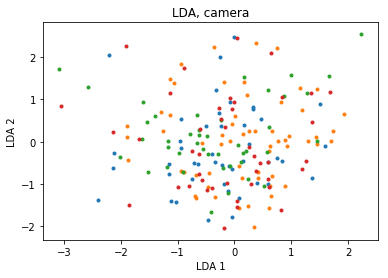

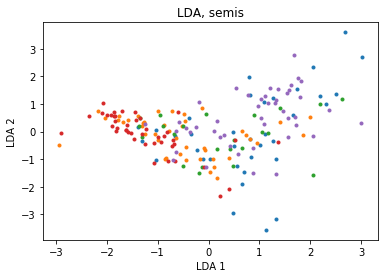

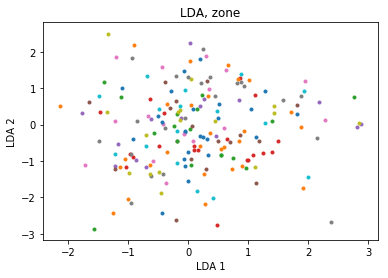

In [3]:
### LDA ###

"""
 On va ici utiliser la méthode LDA, en important les modules LinearDiscriminantAnalysis, train_test_split
 et StandardScaler de la bibliothèque sklearn.
 L'objectif est de trouver une combinaison linéaire des variables qui caractérisent ou séparent 2 ou plus
 classes d'individus.
"""

"""
train_test_split :
La fonction train_test_split va séparer aléatoirement nos données(variables quantitatives et qualitatives)
en plusieurs set : un set de variables quantitatives "entrainées" (qui forment plusieurs groupes prédéfinis selon leurs
caractéristiques/valeurs), un set de variables quantitatives "test" (sur lesquelles on appliquera la LDA,
c'est à dire que l'on va chercher à savoir à quel groupe prédéfini ces variables appartiennent, en se basant
sur les variables "entrainées"). On fait la même chose avec nos variables qualitatives.

On a donc la fonction suivante :
sklearn.model_selection.train_test_split(*arrays,test_size, train_size, random_state, shuffle, stratify)

EXPLICATION DES PARAMETRES
arrays = listes/matrices/dataframe d'index de même taille (on a en entrée un dataframe de variables quantitatives
         et un dataframe de variables qualitatives, pour un même nombre d'individus)
test_size = proportion du jeu de données qui sera testée
train_size = proportion du jeu de données qui sera entrainée (si = None, c'est la valeur complémentaire de test_size
             qui est prise)
random_state = paramètre qui gère le côté aléatoire du "split" : si égal à un entier, alors on aura toujours
               les mêmes données test/entrainées en sortie. Siégal None, ces sorties seront aléatoires
shuffle = booléen. Si égal à True alors les données seront mélangées avant d'être "split"
stratify = None si shuffle = True. Sinon, les données seront "split" par couche superposée (traduction approximative)

EN SORTIE
features_train =  données (variables quantitatives) entrainées
features_tets = données (variables quantitatives) test
labels_train = données (variables qualitatives) entrainées  
labels_test = données (variables qualitatives) test                                         

"""

"""
On utilise la méthode LDA de la classe sklearn.discriminant_analysis :
sklearn.discriminant_analysis.LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, 
                                                         n_components=None, store_covariance=False, tol=0.0001)
EXPLICATION DES PARAMETRES
solver = méthode utilisée pour la réduction de dimension, par défaut égal à svd (décomposition en valeur singulière)
shrinkage = paramètre de réduction en lien avec la paramètre solver, si celui-ci n'est pas 'svd'
priors = ???
n_components = nombre de dimensions auxquelles on souhaite réduire
store_covariance = ???
tol = seuil de tolérance pour la 'svd'

"""

# Préparation des données

features = donnees.iloc[:, 8:16] # features = variables quantitatives
ListeQuali = ["1","4","5","6","7"]
num_quali = 1

for variableQuali in quali:
    valeur = donnees[variableQuali].drop_duplicates().values
    donnees[variableQuali] = donnees[variableQuali].replace(valeur,list(range(len(valeur))))

# Représentation graphique

for j in ListeQuali:
    k = int(j)
    labels = donnees.iloc[:, k].values  # labels = variables qualitatives
    features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, test_size=0.2, random_state=0)
    
    # Feature scaling : on récupère des variables centrées-réduites
    sc = StandardScaler() # méthode de sklearn.preprocessing pour centrer et réduire nos données quantitatives
    features_train = sc.fit_transform(features_train) # On centre et réduit les données quantitatives entrainées
    features_test = sc.transform(features_test) # On centre et on réduit les données quantitatives test
    
    # Application de la LDA
    lda = LDA(n_components = 2) # Utilisation de LDA pour réduire notre espace de variables à deux dimensions
    features_train = lda.fit_transform(features_train, labels_train) # On applique LDA sur nos données quantitatives entrainées
    features_test = lda.transform(features_test) # On applique LDA sur nos données quantitatives test
    
    # Représentation graphique
    for groupe in range(int(min(labels_test)),int(max(labels_test)) + 1):
        x,y = [],[]
        for i in range(len(features_test)):
            if int(labels_test[i]) == groupe:
                x.append(features_test[i][0])
                y.append(features_test[i][1])
        plt.scatter(x,y,marker='.') 
    plt.title("LDA, " + str(quali[num_quali]))
    num_quali = num_quali + 1
    plt.xlabel('LDA 1')
    plt.ylabel('LDA 2')
    plt.show()